Lets implement a class for Black scholes pricing. The variables defined below are s0-initial stock price,k-strike price, sigma = volatility , r - risk free rate , t - time to expiry and der = derivative type(call or put)

In [4]:
from numpy import random as random
import scipy
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
class Blackscholes_pricing:
    def __init__(self,s0,k,sigma,r,t,der):
        self.s0 = s0
        self.k = k
        self.sigma = sigma
        self.r = r
        self.t = t
        self.der = der
    def payoff_func(self,S):
        if self.der == "call":
            payoff = max(0,S-self.k)
        if self.der == "put":
            payoff = max(0,self.k-S)
            return payoff
    def pricing(self):
        d1 = (np.log(self.s0/self.k)+ (self.r  + ((self.sigma**2)/2))*self.t)/(self.sigma*np.sqrt(self.t))
        d2 = (np.log(self.s0/self.k)+ (self.r  - ((self.sigma**2)/2))*self.t)/(self.sigma*np.sqrt(self.t))
        
        if self.der == "call":
            price = (self.s0 * ss.norm.cdf(d1))- (self.k * np.exp(-self.r*self.t)*ss.norm.cdf(d2))
        if self.der == "put":
            price = -(self.s0 * ss.norm.cdf(-d1))+ (self.k * np.exp(-self.r*self.t)*ss.norm.cdf(-d2))
        return price

N(d1) and N(d2) are the risk neutral probabilities of ST > K in the stock and money market numeraires respectively

In [5]:
call = Blackscholes_pricing(100.0,100.0,0.2,0.1,1.0,"call")
call.pricing()

13.269676584660893

In [6]:
put = Blackscholes_pricing(100.0,100.0,0.2,0.1,1.0,"put")
put.pricing()

3.753418388256833

Lets see whether the prices of above call and put for given strikes are vaild according to put-call parity

In [7]:
print(call.pricing())
print(put.pricing() + 100.0 - (100.0*np.exp(-0.1*1.0)))

13.269676584660893
13.269676584660886


we can see above that both the prices are equal

In [8]:
#initial stock price
s0 = 100.0
#strike price
k = 100.0
#risk free rate
r = 0.1
#volatilty
sigma = 0.2
t = 1.0  #time to expiry
mean = np.log(s0) + r-(0.5*sigma**2)*t  #mean of log of final stock price
sd = sigma * np.sqrt(t) # standard deviation of log final stock price
def density(x,mean,sigma):
    return 1 / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(-((np.log(x) - mean) ** 2) / (2 * sigma**2))

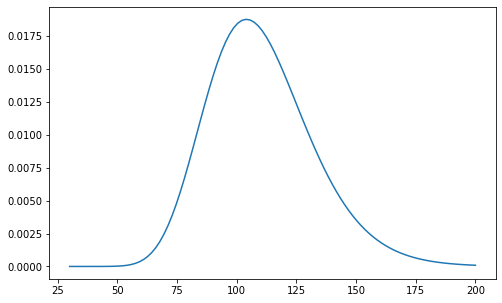

In [10]:
plt.figure(figsize=(8,5))
x = np.linspace(30,200,100)
plt.plot(x,density(x,mean,sigma))
plt.show()

Lets integrte and compute prices by using log normal distribution

In [11]:
from scipy import integrate

In [12]:
def integral(x,k,sd,mean,der):
    if der == "call":
        return (x-k)*ss.lognorm.pdf(x,sd,scale=np.exp(mean))
    if der == "put":
        return (k-x)*ss.lognorm.pdf(x,sd,scale=np.exp(mean))




call = scipy.integrate.quad(integral,k,np.inf,args=(k,sd,mean,"call"))
put = scipy.integrate.quad(integral,0,k,args=(k,sd,mean,"put"))
print(call[0]*np.exp(-r*t))
print(put[0]*np.exp(-r*t))

13.269676584660926
3.753418388256828


In [13]:
mean1 = np.log(s0) + r+(0.5*sigma**2)*t
def pdff(x,sd,m):
    return ss.lognorm.pdf(x,sd,scale=np.exp(m))
nd2 = scipy.integrate.quad(pdff,k,np.inf,args=(sd,mean))
nd1 = scipy.integrate.quad(pdff,k,np.inf,args=(sd,mean1))

In [14]:
print(nd2[0],nd1[0])
call_price = s0*nd1[0] - k * np.exp(-r*t) *nd2[0]
print(call_price)

0.6554217416103069 0.725746882249926
13.269676584662413


Lets compute the price by Monte carlo simulation

In [15]:
np.random.seed(42)
N = 10000000  #no.of simulations
w = ss.norm.rvs((r - 0.5 * sigma**2) * t, np.sqrt(t) * sigma,N)
ST = s0*np.exp(w) # final stock price 
call = np.mean(np.exp(-r*t)*(np.maximum(0,ST-k))) #average price of all simulations

In [16]:
print(call)
put = np.mean(np.exp(-r * t) * np.maximum(k - ST, 0))
print(put)

13.269783529555546
3.7547545678123018


compute the standard error of these prices due to monte carlo simulation

In [17]:
call_err = ss.sem(np.exp(-r *t) * np.maximum(ST - k, 0))  # standard error
put_err = ss.sem(np.exp(-r * t) * np.maximum(k - ST, 0))  # standard error
print(call_err)
print(put_err)

0.005093601327921744
0.0022136467135360615


Binomal tree method

In [18]:
sigma = 0.2 
n = 15000 #no.of steps
dt = t/n #length of each step
u = np.exp(sigma*np.sqrt(dt))  
d = 1.0/u  
a = np.exp(r * dt)
p = (a-d)/(u-d)
q = 1.0-p
V = np.zeros(n+1, dtype=np.float64)
S_T  = np.array([s0*(u**j)*(d**(n-j)) for j in range(n+1)])

In [20]:
V = np.maximum(S_T-k,0.0)
for i in range(n - 1, -1, -1):
    # the price vector is overwritten at each step
    V[:-1] = np.exp(-r * dt) * (p * V[1:] + q * V[:-1])

V[0]

13.269537371978052

In [21]:
values = np.linspace(0.01,10,1000)
prices = []
for i in range(1000):
    call = Blackscholes_pricing(100.0,100.0,values[i],0.1,1.0,"call")
    prices.append(call.pricing())

Plotting Black scholes price as a function of voaltility

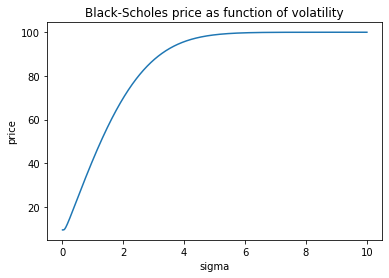

In [23]:
plt.plot(values,prices)
plt.xlabel("sigma")
plt.ylabel("price")
plt.title("Black-Scholes price as function of volatility")
plt.show()

The Black scholes formula is an increasing function of volatility
However for higher voaltilities the graph becomes flat
We can conclude that the model is reliable for volatilities in the range 0-400%